In [1]:
import SimFunctions
import SimClasses
import SimRNG
import SimRNG_Modified
import simpy
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import probplot, kstest
import pickle
warnings.filterwarnings("ignore")
# fix random number seed
np.random.seed(1)


# Data Loading from BikeShare Data

In [71]:
subset_df = pd.read_csv("10_station_subset.csv")
# arrival_df = pd.read_csv("10_Stations_Arrival_Rate_Per_30.csv")
# prob_df = pd.read_csv("10_Station_30min_prob.csv")

In [74]:
subset_df

,Unnamed: 0,Trip Id,Trip_Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,NumOfTrips,Start Time (minutes),End Time (minutes),Start Time (per 30min),End Time (per 30min)
0,259,18158743,3.483333,7389,2022-08-26 00:05:00,College Park- Gerrard Entrance,7406.0,2022-08-26 00:09:00,Victoria St / Queen St E,941,Annual Member,59,5,9,0.0,0.0
1,231,17821126,4.433333,7389,2022-08-13 00:07:00,College Park- Gerrard Entrance,7406.0,2022-08-13 00:12:00,Victoria St / Queen St E,5348,Annual Member,59,7,12,0.0,0.0
2,619,18269298,11.666667,7389,2022-08-30 00:14:00,College Park- Gerrard Entrance,7647.0,2022-08-30 00:25:00,Elm St/ University Ave (East Side),1621,Annual Member,4,14,25,0.0,0.0
3,315,17853590,12.450000,7044,2022-08-14 00:14:00,Church St / Alexander St,7389.0,2022-08-14 00:27:00,College Park- Gerrard Entrance,7132,Casual Member,21,14,27,0.0,0.0
4,737,18108410,2.100000,7647,2022-08-24 00:15:00,Elm St/ University Ave (East Side),7389.0,2022-08-24 00:17:00,College Park- Gerrard Entrance,5208,Casual Member,7,15,17,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,614,18317373,24.700000,7657,2022-08-31 23:50:00,1 Market St - SMART,7269.0,2022-09-01 00:15:00,Toronto Eaton Centre (Yonge St),633,Casual Member,14,1430,15,47.0,0.0
890,128,18216926,5.000000,7269,2022-08-27 23:51:00,Toronto Eaton Centre (Yonge St),7033.0,2022-08-27 23:56:00,Union Station,6716,Annual Member,18,1431,1436,47.0,47.0
891,159,17766801,32.500000,7269,2022-08-10 23:37:00,Toronto Eaton Centre (Yonge St),7406.0,2022-08-11 00:09:00,Victoria St / Queen St E,3099,Casual Member,18,1417,9,47.0,0.0
892,317,17934005,3.983333,7044,2022-08-16 23:38:00,Church St / Alexander St,7389.0,2022-08-16 23:42:00,College Park- Gerrard Entrance,1604,Annual Member,21,1418,1422,47.0,47.0


### Arrival Rates

In [88]:
subset_df['Start Time'] = pd.to_datetime(subset_df['Start Time'])
subset_df['End Time'] = pd.to_datetime(subset_df['End Time'])
subset_df['Start Time (per 30min)'] = (subset_df['Start Time'].dt.hour * 60 + (subset_df['Start Time'].dt.minute // 30) * 30 ) / 30
subset_df['End Time (per 30min)'] = (subset_df['End Time'].dt.hour * 60 + (subset_df['End Time'].dt.minute // 30) * 30 ) / 30

# Group the data by station and 30-minute interval, and count the number of trips that started in each group
Start_Station_HalfHour_Arrivals = subset_df.groupby([subset_df['Start Station Name'], subset_df['Start Station Id'], subset_df['Start Time (per 30min)']]).size().reset_index(name='NumOfStartTrips')

# Calculate the arrival rate at each station and 30-minute interval (trips per hour)
Start_Station_HalfHour_Arrivals['ArrivalRate (per min)'] = Start_Station_HalfHour_Arrivals['NumOfStartTrips'] / 30

arrival_df = Start_Station_HalfHour_Arrivals.sort_values(by="Start Time (per 30min)")
arrival_df


,Start Station Name,Start Station Id,Start Time (per 30min),NumOfStartTrips,ArrivalRate (per min)
104,Elm St/ University Ave (East Side),7647,0.0,1,0.033333
141,Toronto Eaton Centre (Yonge St),7269,0.0,1,0.033333
65,College Park- Gerrard Entrance,7389,0.0,4,0.133333
23,Church St / Alexander St,7044,0.0,1,0.033333
66,College Park- Gerrard Entrance,7389,1.0,3,0.100000
...,...,...,...,...,...
22,1 Market St - SMART,7657,47.0,2,0.066667
64,Church St / Alexander St,7044,47.0,3,0.100000
209,Union Station,7033,47.0,1,0.033333
103,College Park- Gerrard Entrance,7389,47.0,2,0.066667


In [76]:
desc = arrival_df.describe()[1:2].values
mean_arrival_30 = desc[0][1]
mean_arrival_min = desc[0][2]

customer_per_30min = mean_arrival_30
customer_per_min = mean_arrival_min
print(f"Customers Per 30 min = {customer_per_30min}")
print(f"Customers Per min = {customer_per_min}")


Customers Per 30 min = 3.204301075268817
Customers Per min = 0.1068100358422939


- There is approx 0.10 customer every minute in the dataset or 1 customer every 10min

### Probability of Destinations

In [106]:
subset_df['Start Time'] = pd.to_datetime(subset_df['Start Time'])
subset_df['End Time'] = pd.to_datetime(subset_df['End Time'])
subset_df['Start Time (per 30min)'] = (subset_df['Start Time'].dt.hour * 60 + (subset_df['Start Time'].dt.minute // 30) * 30 ) / 30
subset_df['End Time (per 30min)'] = (subset_df['End Time'].dt.hour * 60 + (subset_df['End Time'].dt.minute // 30) * 30 ) / 30

start_end_station_halfhour_trips = subset_df.groupby([subset_df['Start Station Name'], subset_df['Start Station Id'], subset_df['End Station Name'], subset_df['End Station Id'], subset_df['Start Time (per 30min)']]).size().reset_index(name='NumOfTrips')
total_trips = start_end_station_halfhour_trips.groupby(['Start Station Name', 'Start Time (per 30min)'])['NumOfTrips'].sum().reset_index(name='TotalTrips')

start_end_station_prob = pd.merge(start_end_station_halfhour_trips, total_trips, on=['Start Station Name', 'Start Time (per 30min)'])
start_end_station_prob['Probability'] = start_end_station_prob['NumOfTrips'] / start_end_station_prob['TotalTrips']

station_vs_Dest_vs_halfhour = start_end_station_prob.pivot(index=['Start Station Name', 'Start Time (per 30min)'], columns=['End Station Name'], values='Probability').fillna(0)#.reset_index().fillna(0)
name_prob_df = station_vs_Dest_vs_halfhour.sort_values(by="Start Time (per 30min)")
name_prob_df


,End Station Name,1 Market St - SMART,Church St / Alexander St,College Park- Gerrard Entrance,Elm St/ University Ave (East Side),King St E / Jarvis St,Toronto Eaton Centre (Yonge St),Union Station,University Ave / Armoury St,Victoria St / Queen St E,Willcocks St / St. George St
Start Station Name,Start Time (per 30min),,,,,,,,,,
Elm St/ University Ave (East Side),0.0,0.0,0.000000,1.000000,0.00,0.0,0.0,0.00,0.0,0.000000,0.0
Toronto Eaton Centre (Yonge St),0.0,0.0,1.000000,0.000000,0.00,0.0,0.0,0.00,0.0,0.000000,0.0
College Park- Gerrard Entrance,0.0,0.0,0.000000,0.000000,0.25,0.0,0.0,0.00,0.0,0.750000,0.0
Church St / Alexander St,0.0,0.0,0.000000,1.000000,0.00,0.0,0.0,0.00,0.0,0.000000,0.0
College Park- Gerrard Entrance,1.0,0.0,0.333333,0.000000,0.00,0.0,0.0,0.00,0.0,0.666667,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1 Market St - SMART,47.0,0.0,0.000000,0.000000,0.00,0.0,1.0,0.00,0.0,0.000000,0.0
Church St / Alexander St,47.0,0.0,0.000000,0.333333,0.00,0.0,0.0,0.00,0.0,0.666667,0.0
Union Station,47.0,0.0,0.000000,1.000000,0.00,0.0,0.0,0.00,0.0,0.000000,0.0


Real Probability
End Station Name
1 Market St - SMART                   0.000000
Church St / Alexander St              0.333333
College Park- Gerrard Entrance        0.000000
Elm St/ University Ave (East Side)    0.000000
King St E / Jarvis St                 0.000000
Toronto Eaton Centre (Yonge St)       0.000000
Union Station                         0.000000
University Ave / Armoury St           0.000000
Victoria St / Queen St E              0.666667
Willcocks St / St. George St          0.000000
Name: (College Park- Gerrard Entrance, 1.0), dtype: float64

Simulated Probability
{'Church St / Alexander St': 0.29, 'Victoria St / Queen St E': 0.71}


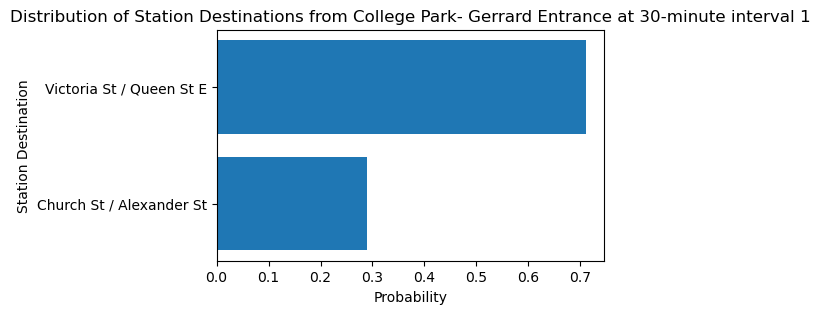

In [108]:
def simulate_travel(prob_df, start_station, start_time):
    try:
        start_row = prob_df.loc[(start_station, start_time)]
        probs = start_row.values
        destination = np.random.choice(start_row.index, p=probs)
        return destination
    except KeyError:
        print(
            f"No data found for start station '{start_station}' and start time '{start_time}'")


monte_carlo = []
for i in range(100):
    start_station = 'College Park- Gerrard Entrance'
    start_time = 1  # 30-minute interval index
    destination = simulate_travel(name_prob_df, start_station, start_time)
    if destination is not None:
        monte_carlo.append(destination)


prob = {}
for s in monte_carlo:
    if s in prob:
        prob[s] += 1
    else:
        prob[s] = 1
for s in prob:
    prob[s] /= len(monte_carlo)

print("Real Probability")
print(name_prob_df.loc[(start_station, start_time)])
print()
print("Simulated Probability")
print(prob)
# Plot the bar chart
plt.figure(figsize=(5, 3))
plt.barh(list(prob.keys()), list(prob.values()))
plt.xlabel('Probability')
plt.ylabel('Station Destination')
plt.title(
    f'Distribution of Station Destinations from {start_station} at 30-minute interval {start_time}')
plt.show()


In [110]:
station_vs_Dest_vs_halfhour = start_end_station_prob.pivot(index=['Start Station Id', 'Start Time (per 30min)'], columns=['End Station Id'], values='Probability').fillna(0)
prob_df = station_vs_Dest_vs_halfhour.sort_values(by="Start Time (per 30min)")
prob_df

End Station Id                           7009.0  7033.0    7044.0  7066.0  \
Start Station Id Start Time (per 30min)                                     
7269             0.0                        0.0    0.00  1.000000     0.0   
7044             0.0                        0.0    0.00  0.000000     0.0   
7647             0.0                        0.0    0.00  0.000000     0.0   
7389             0.0                        0.0    0.00  0.000000     0.0   
                 1.0                        0.0    0.00  0.333333     0.0   
...                                         ...     ...       ...     ...   
7033             47.0                       0.0    0.00  0.000000     0.0   
7044             47.0                       0.0    0.00  0.000000     0.0   
7389             47.0                       0.0    0.00  0.000000     0.0   
7269             47.0                       0.0    0.25  0.000000     0.0   
7657             47.0                       0.0    0.00  0.000000     0.0   

End Station Id                           7269.0    7389.0    7406.0  7408.0  \
Start Station Id Start Time (per 30min)                                       
7269             0.0                        0.0  0.000000  0.000000     0.0   
7044             0.0                        0.0  1.000000  0.000000     0.0   
7647             0.0                        0.0  1.000000  0.000000     0.0   
7389             0.0                        0.0  0.000000  0.750000     0.0   
                 1.0                        0.0  0.000000  0.666667     0.0   
...                                         ...       ...       ...     ...   
7033             47.0                       0.0  1.000000  0.000000     0.0   
7044             47.0                       0.0  0.333333  0.666667     0.0   
7389             47.0                       0.0  0.000000  0.500000     0.0   
7269             47.0                       0.0  0.000000  0.750000     0.0   
7657             47.0                       1.0  0.000000  0.000000     0.0   

End Station Id                           7647.0  7657.0  
Start Station Id Start Time (per 30min)                  
7269             0.0                       0.00     0.0  
7044             0.0                       0.00     0.0  
7647             0.0                       0.00     0.0  
7389             0.0                       0.25     0.0  
                 1.0                       0.00     0.0  
...                                         ...     ...  
7033             47.0                      0.00     0.0  
7044             47.0                      0.00     0.0  
7389             47.0                      0.50     0.0  
7269             47.0                      0.00     0.0  
7657             47.0                      0.00     0.0  

[279 rows x 10 columns]

# Global Variables

In [81]:
global Departure_Rate 

In [82]:
Departure_Rate = SimRNG_Modified.Lognormal(ZSimRNG, 0.2, np.sqrt(0.066), 6)


# Classes

In [2]:
class Station:
    def __init__(self, station_id, level, capacity):
        self.id = station_id
        self.level = level
        self.capacity = capacity
        self.bikes = {}
        self.bike_list = []
        for i in range(level):
            bike_id = f"{station_id}-{i+1}"  # create unique bike ID
            self.bikes[bike_id] = True  # mark bike as available
            self.bike_list.append(bike_id)
            
    def rent_bike(self):
        # Request a bike from the station
        if self.level > 0:
            if self.bike_list:
                random_index = np.random.randint(0, len(self.bike_list))
                bike_id = self.bike_list.pop(random_index)
                self.level -= 1
                return bike_id
        return None
    
    def return_bike(self, bike_id):
        # # Return a bike to the station
        if self.level < self.capacity:
            self.bike_list.append(bike_id)
            self.level += 1

    def Get_Bike_List(self):
        return self.bike_list
    
class Customer:
    def __init__(self, customer_id, start_station, bike = None):
        self.customer_id = customer_id
        self.start_station = start_station
        self.end_id = 0
        self.station_level = 0
        self.bike = bike

    def rent_bike(self):
        station = StationDict[self.start_station]
        print(f"Customer Arrives at S{station.id} with Level: {station.level}")

        if station.level > 0:
            self.bike = station.rent_bike()
            self.station_level = station.level
            print("(Customer Rent Bikes) Customer ID: {} | Bike ID {} || From: S{} -> Remaining Level: {}".format(self.customer_id,
                                                                                                            self.bike,
                                                                                                            self.start_station,
                                                                                                            self.station_level))
            SimFunctions.Schedule(Calendar, "Departure", 0.1)
        else:
            print(f"    Customer {self.customer_id} CANNOT RENT BIKE -- EMPTY STATION {self.start_station} w/ level {self.station_level} -- EMPTY")
            
    def return_bike(self, end_station, bike):
        destination_station = StationDict[end_station]
        destination_station.return_bike(bike)
        self.station_level = destination_station.level
        
        

In [ ]:
class Station:
    def __init__(self, station_id, level, capacity):
        self.id = station_id
        self.level = level
        self.capacity = capacity
        self.bikes = {}
        self.bike_list = []
        for i in range(level):
            bike_id = f"{station_id}-{i+1}"  # create unique bike ID
            self.bikes[bike_id] = True  # mark bike as available
            self.bike_list.append(bike_id)
    
    def Get_Arrival_Rate(T):
        
        
    def rent_bike(self):
        # Request a bike from the station
        if self.level > 0:
            if self.bike_list:
                random_index = np.random.randint(0, len(self.bike_list))
                bike_id = self.bike_list.pop(random_index)
                self.level -= 1
                return bike_id
        return None

    def return_bike(self, bike_id):
        # # Return a bike to the station
        if self.level < self.capacity:
            self.bike_list.append(bike_id)
            self.level += 1

    def Get_Bike_List(self):
        return self.bike_list

class Customer:
    def __init__(self, customer_id, start_station, bike=None):
        self.customer_id = customer_id
        self.start_station = start_station
        self.end_id = 0
        self.station_level = 0
        self.bike = bike

    def rent_bike(self):
        station = StationDict[self.start_station]
        self.station_level = station.level - 1
        self.bike = station.rent_bike()
        print("(CUSTOMER ARRIVAL) Customer ID: {} | Bike ID {} || Station ID: {} -> Level: {}".format(self.customer_id,
                                                                                                      self.bike,
                                                                                                      self.start_station,
                                                                                                      station.level))
        SimFunctions.Schedule(Calendar, "Departure", Departure_Rate)

    def return_bike(self, end_station, bike):
        destination_station = StationDict[end_station]
        self.station_level = destination_station.level
        destination_station.return_bike(bike)


In [114]:
arrival_df.head()

,Start Station Name,Start Station Id,Start Time (per 30min),NumOfStartTrips,ArrivalRate (per min)
104,Elm St/ University Ave (East Side),7647,0.0,1,0.033333
141,Toronto Eaton Centre (Yonge St),7269,0.0,1,0.033333
65,College Park- Gerrard Entrance,7389,0.0,4,0.133333
23,Church St / Alexander St,7044,0.0,1,0.033333
66,College Park- Gerrard Entrance,7389,1.0,3,0.100000


In [136]:
# Set the time interval T and station ID s_id
T = 0
s_id = 7647

temp = arrival_df[(arrival_df["Start Time (per 30min)"] == T) & (arrival_df["Start Station Id"] == s_id)]["ArrivalRate (per min)"].values[0]
temp
#arrival_rate = temp["ArrivalRate (per min)"].values[0]
#arrival_rate


0.03333333333333333

In [ ]:

def Customer_Arrival_Rate(station_id, T):
    try:
        arrival_rate = arrival_df[(arrival_df["Start Time (per 30min)"] == T) & (arrival_df["Start Station Id"] == s_id)]["ArrivalRate (per min)"].values[0]
    e
    return arrival_rate


def Destination(customer, retrial=0):
    start_station = customer.start_station
    destination = simulate_travel(prob_df, start_station)
    end_id = destination

    end_station = StationDict[end_id]
    if customer.bike is None:
        print(" Customer ID: {} Leaves from empty | From: {} -> Remaining Level {}".format(customer.customer_id,
                                                                                           customer.start_station,
                                                                                           customer.station_level))
    elif retrial == 1:
        pass

    elif retrial == 0 and customer.bike is not None:
        print(" (DEPARTING) Customer ID: {} | Bike ID: {} || From: S{} -> Level {} | To: S{} -> Level {}".format(customer.customer_id,
                                                                                                                 customer.bike,
                                                                                                                 customer.start_station,
                                                                                                                 customer.station_level,
                                                                                                                 end_station.id,
                                                                                                                 end_station.level))
        # print("-------------------------------------------------------------------------")
    return end_id


# Functions

In [3]:
def Start():
    SimFunctions.Schedule(Calendar, "Customer_Arrival", SimRNG_Modified.Expon(ZSimRNG, 0, 1))
    
def NextCustomerID():
    if not hasattr(NextCustomerID, "counter"):
        NextCustomerID.counter = 0
    NextCustomerID.counter += 1
    return NextCustomerID.counter

## Probabilistic Functions

The flow rate μt,i, j in time interval t, t = 1,...,48
from station i to j is calculated from the total number of observed trips from station i to j in that interval,
divided by the time that the station is not empty. (This accounts for the censoring that happens when no
bikes are available, but does not account for the censoring that happens when a biker tries to return a bike
to a full rack and must go to an adjacent station.)

The arrival process of potential bikers at stations are independent across stations,
and at each station i is a time-varying Poisson process with rate μt,i = ∑j μt,i, j in time interval t, with the
arrival times rounded to the nearest minute. The destination of a biker leaving station i in time interval t
has a multinomial distribution with the probability of going to station j estimated by Pt,i, j = μt,i, j /μt,i.

In [ ]:
import numpy as np
import math


def Customer_Arrival_Rate(station_id, T):
    station = StationDict[station_id]
    rate_sum = sum([station.arrival_rates[j][T] for j in range(1, 4)])
    arrival_rate = max(1, np.round(rate_sum))  # round to the nearest integer
    arrival_prob = [station.arrival_rates[j][T] / rate_sum if rate_sum > 0 else 1/3 for j in range(1, 4)]
    arrival_type = np.random.choice([1, 2, 3], p=arrival_prob)
    return arrival_type, arrival_rate


def Destination(customer, T):
    start_station = StationDict[customer.start_station]
    destination_prob = [start_station.arrival_rates[j][T] / sum(start_station.arrival_rates[k][T] for k in range(1, 4)) for j in range(1, 4)]
    destination_type = np.random.choice([1, 2, 3], p=destination_prob)
    destination_station = StationDict[destination_type]
    
    start_station = customer.start_station
    destination = simulate_travel(prob_df, start_station)
    end_id = destination

    end_station = StationDict[end_id]
    
    if customer.bike is None:
        print(" Customer ID: {} Leaves from empty | From: {} -> Remaining Level {}".format(customer.customer_id,
                                                                                           customer.start_station,
                                                                                           customer.station_level))
    elif retrial == 1:
        pass

    elif retrial == 0 and customer.bike is not None:
        print(" (DEPARTING) Customer ID: {} | Bike ID: {} || From: S{} -> Level {} | To: S{} -> Level {}".format(customer.customer_id,
                                                                                                                 customer.bike,
                                                                                                                 customer.start_station,
                                                                                                                 customer.station_level,
                                                                                                                 end_station.id,
                                                                                                                 end_station.level))
        # print("-------------------------------------------------------------------------")
    return end_id


## Trip Process Functions

In [5]:
def Customer_Arrival(station_id, empty_error, CustomerList, t):
    SimFunctions.Schedule(Calendar, "Customer_Arrival", 
                          SimRNG_Modified.Expon(ZSimRNG, 0.5, 1))
    station = StationDict[station_id]
    customer_id = NextCustomerID()
    customer = Customer(customer_id, station_id)
    customer.start_station = station_id
    customer.station_level = station.level

################################################################
# STATION EMPTY
################################################################
    if customer.station_level == 0:
        print(f"    EMPTY -- Customer {customer.customer_id} CANNOT RENT BIKE | S{customer.start_station} -> level {customer.station_level} -- EMPTY")
        empty_error += 1
    else:
        CustomerList.append(customer)
        customer.rent_bike()

    return Customer_Arrival_Rate(station_id), empty_error, customer


def Departure(station_id, customer):
    station = StationDict[station_id]
    end_id = Destination(customer, 0)
    customer.end_id = end_id
    SimFunctions.Schedule(Calendar, "Bike_Arrival",
                          15 * SimRNG_Modified.Lognormal(ZSimRNG, 0.5, np.sqrt(0.066), 4))
    return end_id


def Bike_Arrival(end_id, Full_Error, CustomerList, temp_customer):
    
    end_station = StationDict[end_id] 
    
    if end_station.level < end_station.capacity:
        for customer in CustomerList:
            if customer.end_id == end_station.id and customer.bike is not None:
                customer.return_bike(customer.end_id, customer.bike)
                print("     (BIKE RETURNED) Customer ID: {} | Bike ID: {} || To: S{} -> Level {} | From: S{}".format(customer.customer_id,
                                                                                                                        customer.bike,
                                                                                                                        end_station.id,
                                                                                                                        end_station.level,
                                                                                                                        customer.start_station
                                                                                                                        ))
                CustomerList.remove(customer)
                return Full_Error

################################################################
#STATION FULL
################################################################
    else:
        for customer in CustomerList:
            customer_end_station = StationDict[customer.start_station]
            if customer.end_id == customer_end_station.id and customer_end_station.level >= customer_end_station.capacity:
                temp_customer = customer
                print(f"     FULL --  Customer ID: {customer.customer_id} || To: S{end_station.id} -> Level {end_station.level} | Capacity {end_station.capacity} || From: S{customer.start_station} | Bike ID: {customer.bike}")
                Full_Error += 1
                SimFunctions.Schedule(Calendar, "Retrial", SimRNG_Modified.Expon(ZSimRNG, 2, 5))
                Retrial(end_id, Full_Error, CustomerList, temp_customer=temp_customer)
                return Full_Error
            else:
                pass
    
    return Full_Error


def Retrial(end_id, Full_Error, CustomerList, temp_customer):
    customer = temp_customer
    for customer in CustomerList:
        customer_end_station = StationDict[customer.start_station]
        if customer.end_id == customer_end_station.id and customer_end_station.level >= customer_end_station.capacity:
            pre_end_id = customer.end_id
            start_id = customer.start_station
            end_id = pre_end_id
            condition = False

            while not condition:
                if pre_end_id == end_id or start_id == end_id:
                    end_id = Destination(customer, retrial=1)
                else:
                    customer.end_id = end_id
                    condition = True

            print(f"    (NEW STATION) Customer ID: {customer.customer_id} tries new station S{customer.end_id}")
            SimFunctions.Schedule(Calendar, "Bike_Arrival", 
                                15 *SimRNG_Modified.Lognormal(ZSimRNG, 0.5, np.sqrt(0.066), 4))

            return Full_Error
    return Full_Error

# Simulation

In [6]:
NextCustomerID.counter = 0

ZSimRNG = SimRNG_Modified.InitializeRNSeed()

Calendar = SimClasses.EventCalendar()

Queue = SimClasses.FIFOQueue()
Wait = SimClasses.DTStat()
Bikes = SimClasses.Resource()

TheCTStats = []
TheDTStats = []
TheQueues = []
TheResources = []

CustomerList = []
Full_Error_list = []
Empty_Error_list = []

MeanTBA = 0.5
MeanTR = 0.5
MeanST = 0.5

Phases = 3
RunLength = 50
WarmUp = 5
end_id = 1


for days in range(0, 5, 1):
    Full_Error = 0
    Empty_Error = 0
    
    inital_station_id = np.random.random_integers(1, 3)
    station_id = inital_station_id
    
    # Initialize the stations and create a dictionary mapping station IDs to Station instances
    Stations = [Station(station_id=1, level=5, capacity=5), Station(station_id=2, level=35, capacity=40), Station(station_id=3, level=25, capacity=25)]
    StationDict = {station.id: station for station in Stations}
    for station_id, station in StationDict.items():
        print(f"Station {station_id} Inital Bike List: {station.Get_Bike_List()}")
        
    SimFunctions.SimFunctionsInit(Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
    SimFunctions.Schedule(Calendar, "Start", SimRNG_Modified.Expon(ZSimRNG, 0, 1))
        
    NextEvent = Calendar.Remove()
    SimClasses.Clock = NextEvent.EventTime
    if NextEvent.EventType == "Start":
        Start()

    for T in [i for i in range(0,3)]:  # T = hours intervals
        print(f"          Clock Hour | {T}")
        for minutes in [i for i in range(1, 31)]:  # 30 min intervals
            print("             Minute | {}".format(minutes))
            
            NextEvent = Calendar.Remove()
            SimClasses.Clock = NextEvent.EventTime

            if NextEvent.EventType == "Customer_Arrival":
                station_id, Empty_Error, customer = Customer_Arrival(station_id, Empty_Error, CustomerList, T)

            elif NextEvent.EventType == "Departure":
                end_id = Departure(station_id, customer)
            
            elif NextEvent.EventType == "Bike_Arrival":
                Full_Error = Bike_Arrival(end_id, Full_Error, CustomerList, customer)
            
            elif NextEvent.EventType == "Retrial":
                Full_Error = Retrial(end_id, Full_Error, CustomerList, customer)
               
    for station_id, station in StationDict.items():
        print(f"Station {station_id} Bike List: {station.Get_Bike_List()}")

    print(f"Num of Full Errors: {Full_Error}")
    print(f"Num of Empty Errors: {Empty_Error}")
    Full_Error_list.append(Full_Error)
    Empty_Error_list.append(Empty_Error)
    print(f"End of Day {days}")
    print("--------------------------------------------------------------------------------------------------------------------------------------------------")


Station 1 Inital Bike List: ['1-1', '1-2', '1-3', '1-4', '1-5']
Station 2 Inital Bike List: ['2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9', '2-10', '2-11', '2-12', '2-13', '2-14', '2-15', '2-16', '2-17', '2-18', '2-19', '2-20', '2-21', '2-22', '2-23', '2-24', '2-25', '2-26', '2-27', '2-28', '2-29', '2-30', '2-31', '2-32', '2-33', '2-34', '2-35']
Station 3 Inital Bike List: ['3-1', '3-2', '3-3', '3-4', '3-5', '3-6', '3-7', '3-8', '3-9', '3-10', '3-11', '3-12', '3-13', '3-14', '3-15', '3-16', '3-17', '3-18', '3-19', '3-20', '3-21', '3-22', '3-23', '3-24', '3-25']
          Clock Hour | 8
             Minute | 1
Customer Arrives at S3 with Level: 25
(Customer Rent Bikes) Customer ID: 1 | Bike ID 3-12 || From: S3 -> Remaining Level: 24
             Minute | 2
 (DEPARTING) Customer ID: 1 | Bike ID: 3-12 || From: S3 -> Level 24 | To: S2 -> Level 35
             Minute | 3
Customer Arrives at S2 with Level: 35
(Customer Rent Bikes) Customer ID: 2 | Bike ID 2-13 || From: S2 -> 

In [7]:
for station_id, station in StationDict.items():
    print(f"Station {station_id} Bike List: {station.Get_Bike_List()}")
    print(station.level)
    print(station.capacity)
print(f"Num of Full Errors: {Full_Error}")
print(f"Num of Empty Errors: {Empty_Error}")


Station 1 Bike List: ['2-27', '3-19']
2
5
Station 2 Bike List: ['2-8', '2-9', '2-11', '2-12', '2-13', '2-16', '2-24', '2-25', '2-29', '2-31', '2-34', '2-35', '3-8', '2-30', '3-10', '2-19', '2-3', '3-6', '2-18', '3-17', '2-30', '3-25', '3-3', '3-11', '3-4', '2-22', '1-2', '2-32', '3-22']
29
40
Station 3 Bike List: ['3-1', '3-2', '3-7', '3-11', '3-20', '3-18', '3-21', '2-5', '3-15', '2-8', '2-28', '1-5', '2-5', '2-33']
14
25
Num of Full Errors: 9
Num of Empty Errors: 7


In [8]:
print(f"Num of Full Errors: {Full_Error_list}")
print(f"Num of Empty Errors: {Empty_Error_list}")

Num of Full Errors: [0, 7, 5, 8, 9]
Num of Empty Errors: [23, 11, 6, 7, 7]
